In [2]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from shapely.geometry import Point
from matplotlib.lines import Line2D
import os

ox.settings.log_console = False
ox.settings.use_cache = True

In [3]:
OUTPUT_DIR = "../data/osmnx"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
def fetch_worldpop_data(url: str, data_dir: str) -> str:
    zip_fname = url.split("/")[-1]
    zip_fpath = os.path.join(data_dir, zip_fname)
    csv_fname = zip_fname.replace(".zip", ".csv")
    csv_fpath = os.path.join(data_dir, csv_fname)

    # Download if missing
    if not os.path.exists(zip_fpath):
        print(f"Downloading {zip_fname}...")
        import requests

        resp = requests.get(url, stream=True)
        resp.raise_for_status()
        with open(zip_fpath, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Saved {zip_fname} -> {zip_fpath}")
    else:
        print(f"{zip_fname} already exists. Skipping download.")

    # Unzip if needed
    if not os.path.exists(csv_fpath):
        print(f"Extracting {csv_fname}...")
        import zipfile

        with zipfile.ZipFile(zip_fpath, "r") as archive:
            archive.extractall(data_dir)
        print(f"Extracted to {data_dir}")
    else:
        print(f"{csv_fname} already exists. Skipping extraction.")

    return csv_fpath


worldpop_url = (
    "https://data.worldpop.org/GIS/Population_Density/"
    "Global_2000_2020_1km_UNadj/2020/PAK/pak_pd_2020_1km_UNadj_ASCII_XYZ.zip"
)

WORLDPOP_DIR = "../data/worldpop"
WORLDPOP_CSV_FPATH = fetch_worldpop_data(worldpop_url, WORLDPOP_DIR)
print("WorldPop CSV ready at:", WORLDPOP_CSV_FPATH)

pak_pd_2020_1km_UNadj_ASCII_XYZ.zip already exists. Skipping download.
pak_pd_2020_1km_UNadj_ASCII_XYZ.csv already exists. Skipping extraction.
WorldPop CSV ready at: ../data/worldpop/pak_pd_2020_1km_UNadj_ASCII_XYZ.csv


#### Coordinate system transformation + Spatial data preparation


In [5]:
lahore_str = "Lahore District, Pakistan"
boundary = ox.geocode_to_gdf(lahore_str)  # Get administrative Boundary for Lahore

# Central point
latitude = 31.456845
longitude = 74.407836

gdf = gpd.GeoDataFrame(  # create gdf w/ single point i.e Lahore's center
    {"geometry": [Point(longitude, latitude)]},
    crs="EPSG:4326",  # WGS84
)

gdf_utm = ox.projection.project_gdf(gdf)  # Convert from global zone to local zone

#### Lahore Plot (Polygon)


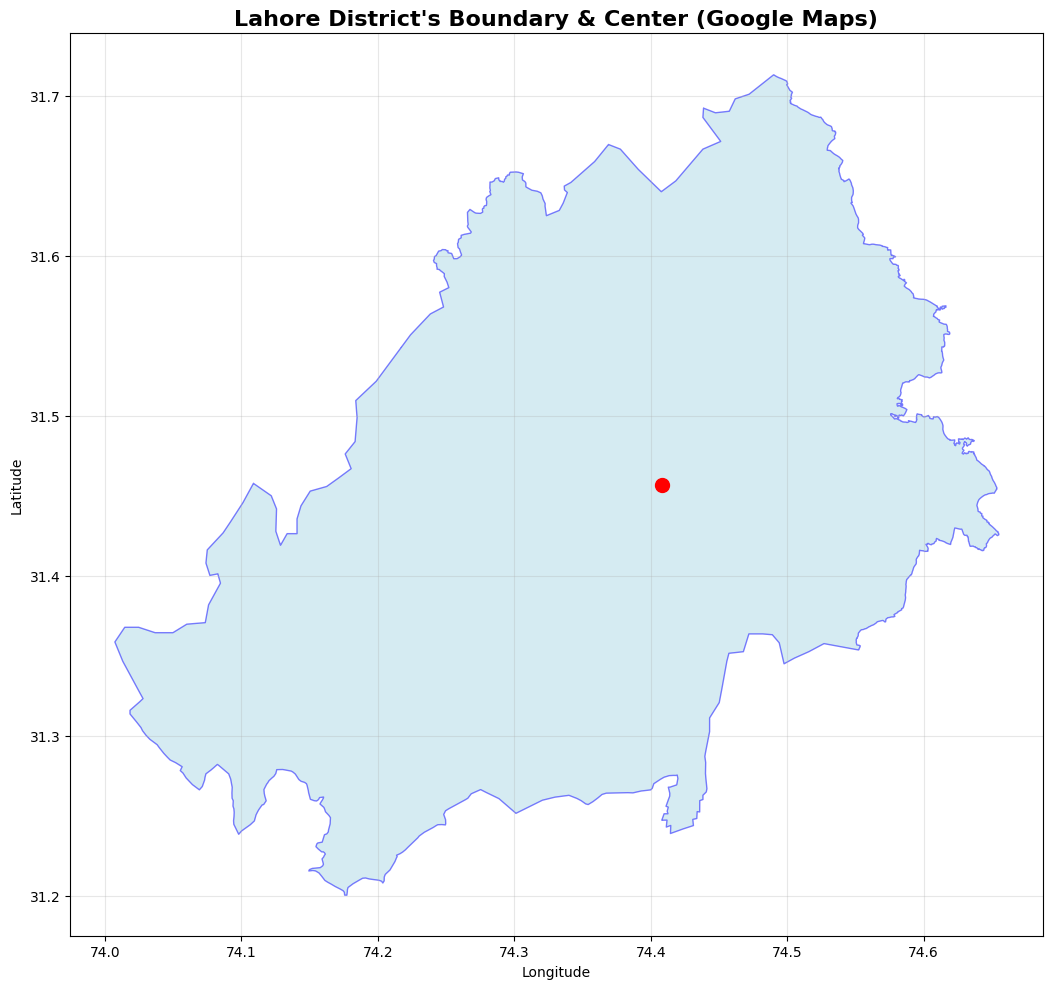

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))

boundary.plot(
    ax=ax, color="lightblue", edgecolor="blue", alpha=0.5, label="Lahore District"
)
gdf.plot(ax=ax, color="red", markersize=100)

ax.set_title(
    "Lahore District's Boundary & Center (Google Maps)",
    fontsize=16,
    fontweight="bold",
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
utm_crs = gdf_utm.crs
print("UTM CRS:", utm_crs)

if utm_crs is None:
    raise TypeError("`utm_crs` is none.")

UTM CRS: EPSG:32643


In [7]:
pois = ox.features_from_place(
    lahore_str,
    {
        "amenity": ["hospital", "university", "college"],
        "shop": ["supermarket", "mall"],
        "building": ["retail", "commercial"],
    },
)

In [8]:
# Feature engineering and Data Preparation


def filter_pois(df, conditions):
    return df[conditions][["geometry", "name"]].copy()


hospitals = filter_pois(pois, pois["amenity"] == "hospital").assign(type="hospital")
universities = filter_pois(
    pois, pois["amenity"].isin(["university", "college"])
).assign(type="education")

markets = filter_pois(
    pois,
    pois["shop"].isin(["supermarket", "mall"])
    | pois["building"].isin(["retail", "commercial"]),
).assign(type="market")

all_pois = gpd.GeoDataFrame(
    gpd.pd.concat([hospitals, universities, markets]), crs=pois.crs
)

pois = None

In [9]:
# Convert polygons to points

all_pois.geometry = all_pois.geometry.apply(
    lambda geom: (
        geom.centroid if geom.geom_type in ["Polygon", "MultiPolygon"] else geom
    )
)

In [11]:
if utm_crs is None:
    raise TypeError("`utm_crs` is none.")

all_pois.to_file(f"{OUTPUT_DIR}/all-pois.gpkg", layer="pois", driver="GPKG")
all_pois = all_pois.to_crs(utm_crs)
all_pois.head(3)

geometry  \
element id                                          
node    271105745  POINT (440299.449 3482608.993)   
        526681507  POINT (434629.628 3485496.606)   
        563684371  POINT (437375.331 3486167.245)   

                                           name      type  
element id                                                 
node    271105745  DHA Medical Center Phase III  hospital  
        526681507              PU Health Center  hospital  
        563684371         یونائیٹڈ کرسچن ہسپتال  hospital

In [18]:
if os.path.exists(f"{OUTPUT_DIR}/network.graphml"):
    print("Found graph. Loading.")
    G = ox.load_graphml(f"{OUTPUT_DIR}/network.graphml")
else:
    print("Graph not found. Computing...")
    G = ox.graph_from_polygon(
        boundary.geometry.iloc[0], network_type="drive", truncate_by_edge=True
    )

    G = ox.project_graph(G, to_crs=utm_crs)
    ox.save_graphml(G, filepath=f"{OUTPUT_DIR}/network.graphml")

Found graph. Loading.


In [19]:
if utm_crs is None:
    raise TypeError("`utm_crs` is none.")

boundary = boundary.to_crs(utm_crs)

BOUNDARY_FPATH = f"{OUTPUT_DIR}/lahore_boundary.gpkg"
if not os.path.exists(BOUNDARY_FPATH):
    print("Saving Lahore's boundary info.")
    boundary.to_file(BOUNDARY_FPATH, driver="GPKG")

In [20]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
major_roads = edges[edges["highway"].isin(["primary", "secondary", "trunk"])]

### Visualization


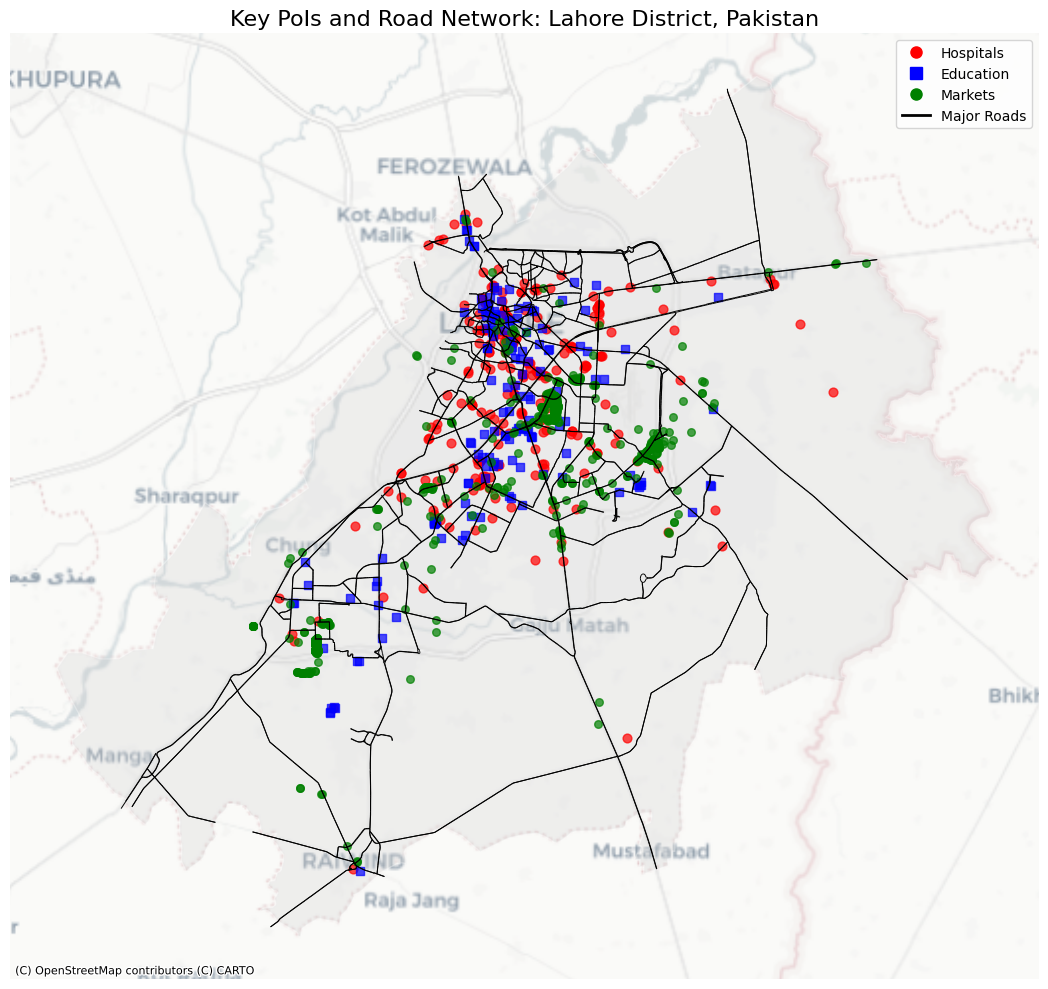

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

boundary.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.3)
major_roads.plot(ax=ax, color="black", linewidth=0.7)

poi_colors = {"hospital": "red", "education": "blue", "market": "green"}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois["type"] == ptype]
    subset.plot(
        ax=ax,
        color=color,
        markersize=30 + 10 * (ptype == "hospital"),
        alpha=0.7,
        marker="o" if ptype != "education" else "s",
    )

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color="red", lw=0, marker="o", markersize=8, label="Hospitals"),
    Line2D([0], [0], color="blue", lw=0, marker="s", markersize=8, label="Education"),
    Line2D([0], [0], color="green", lw=0, marker="o", markersize=8, label="Markets"),
    Line2D([0], [0], color="black", lw=2, label="Major Roads"),
]
ax.legend(handles=legend_elements, loc="upper right")
ax.set_title(f"Key PoIs and Road Network: {lahore_str}", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/lahore-poi-network.png", dpi=300)
plt.show()

## Points of Interest


In [15]:
print(f"Hospitals: {len(hospitals)}")
print(f"Education Institutions: {len(universities)}")
print(f"Markets: {len(markets)}")
print(f"Total POIs: {len(all_pois)}")
print(f"Road Network: {len(edges)} edges")

Hospitals: 227
Education Institutions: 160
Markets: 804
Total POIs: 1191
Road Network: 378090 edges


In [16]:
basic_stats = ox.basic_stats(G)

In [17]:
print("BASIC NETWORK STATISTICS:")
print(f"Number of nodes: {basic_stats['n']}")
print(f"Number of edges: {basic_stats['m']}")
print(f"Total street length: {basic_stats['street_length_total']:,.0f} meters")
print(f"Average street length: {basic_stats['street_length_avg']:.1f} meters")
print(f"Intersection count: {basic_stats['intersection_count']}")

BASIC NETWORK STATISTICS:
Number of nodes: 145131
Number of edges: 378090
Total street length: 17,574,097 meters
Average street length: 88.1 meters
Intersection count: 118202


### Discard Unnecessary Population Info Rows

In [23]:
CLIPPED_GPKG = f"{WORLDPOP_DIR}/worldpop_lahore_rows.gpkg"

if os.path.exists(CLIPPED_GPKG):
    print("Loading existing Lahore population density file.")
    lahore_pop_gdf = gpd.read_file(CLIPPED_GPKG)
else:
    print("Generating Lahore's population density in particular.")
    pk_pop_df = pd.read_csv(WORLDPOP_CSV_FPATH)

    pk_pop_gdf = gpd.GeoDataFrame(
        pk_pop_df,
        geometry=gpd.points_from_xy(pk_pop_df.X, pk_pop_df.Y),
        crs="EPSG:4326",  # for some godforsaken reason, boundary.crs doesn't work here...
    )

    if not boundary.crs:
        raise RuntimeError("`boundary.crs` was None")

    pk_pop_gdf = pk_pop_gdf.to_crs(boundary.crs)
    lahore_pop_gdf = gpd.clip(pk_pop_gdf, boundary)
    lahore_pop_gdf = lahore_pop_gdf[lahore_pop_gdf["Z"] > 0]

    if len(lahore_pop_gdf) > 0:
        lahore_pop_gdf.to_file(CLIPPED_GPKG, driver="GPKG")
        print(f"Saved clipped data to {CLIPPED_GPKG}")
    else:
        print("Warning: No valid population data found in Lahore boundary.")


if not utm_crs:
    raise RuntimeError("`utm_crs` was None")

lahore_pop_gdf = lahore_pop_gdf.to_crs(utm_crs)

Loading existing Lahore population density file.


In [24]:
lahore_pop_gdf = lahore_pop_gdf.rename(
    columns={"X": "longitude", "Y": "latitude", "Z": "population"}
)

lahore_pop_gdf.head(3)

,longitude,latitude,population,geometry
0,74.202916,31.212083,746.548706,POINT (424073.354 3453380.183)
1,74.194583,31.212083,612.143555,POINT (423279.534 3453385.936)
2,74.186250,31.212083,733.004272,POINT (422485.712 3453391.749)


### Prepare CityLines Data

In [25]:
CITYLINES_DIR = "../data/citylines"
os.makedirs(CITYLINES_DIR, exist_ok=True)


CITYLINES_SRCS = [
    (
        "https://www.citylines.co/api/lahore/raw_source/sections",
        "lahore_sections.geojson",
    ),
    (
        "https://www.citylines.co/api/lahore/raw_source/stations",
        "lahore_stations.geojson",
    ),
    (
        "https://www.citylines.co/api/data/lahore/lines_systems_and_modes",
        "lahore_lines_systems_and_modes.json",
    ),
]


def download_json(url: str, fname: str, save_dir: str):
    fpath = os.path.join(save_dir, fname)

    if os.path.exists(fpath):
        print(f"{fname} already exists. Skipping download.")
        return fpath

    print(f"Downloading {fname}...")
    import requests

    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(fpath, "w", encoding="utf-8") as f:
            f.write(response.text)
        print(f"Saved {fname} to {fpath}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {fname}: {e}")
        return None

    return fpath


for url, fname in CITYLINES_SRCS:
    download_json(url, fname, CITYLINES_DIR)

lahore_sections.geojson already exists. Skipping download.
lahore_stations.geojson already exists. Skipping download.
lahore_lines_systems_and_modes.json already exists. Skipping download.


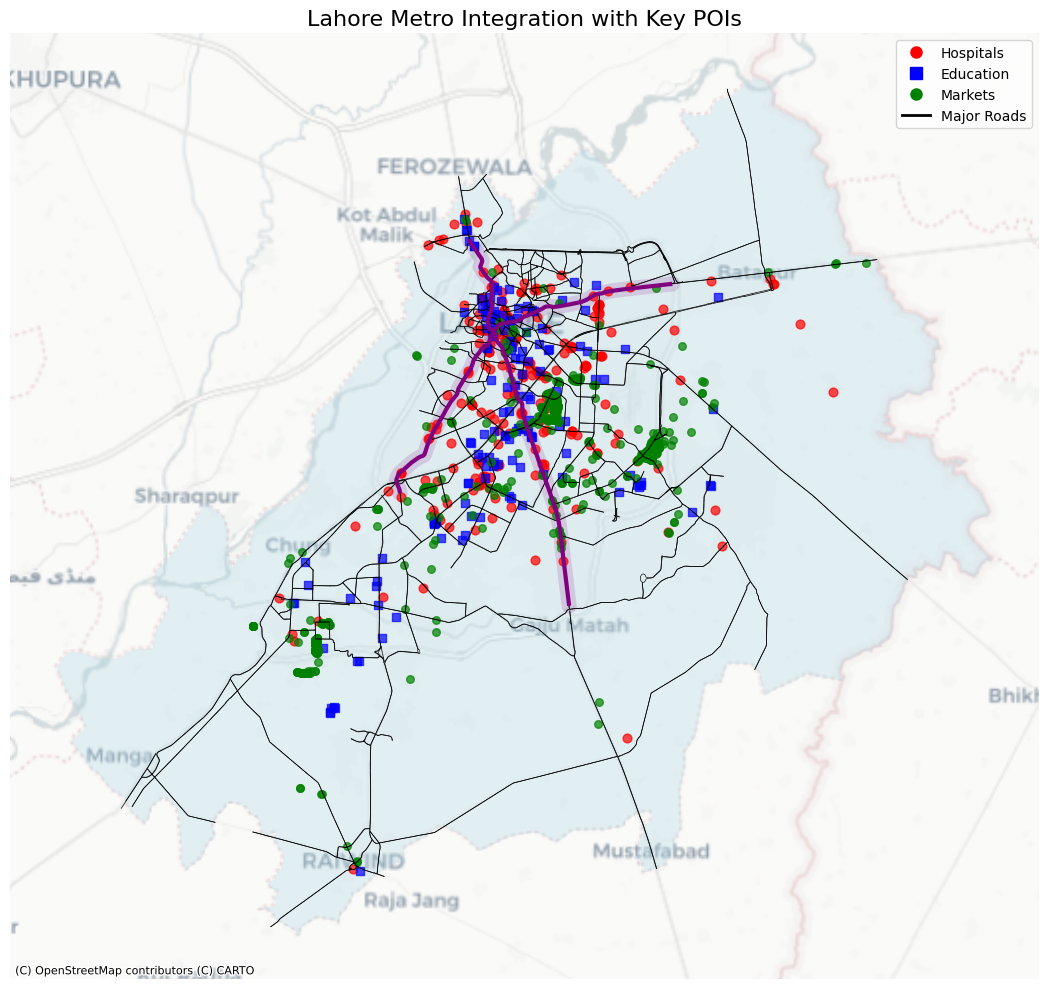

In [30]:
if utm_crs is None:
    raise TypeError("`utm_crs` is None")

metro_routes = gpd.read_file(f"{CITYLINES_DIR}/lahore_sections.geojson").to_crs(utm_crs)
metro_service_areas = gpd.GeoDataFrame(geometry=metro_routes.buffer(500), crs=utm_crs)

fig, ax = plt.subplots(figsize=(12, 10))

boundary.plot(ax=ax, color="lightblue", alpha=0.3)
major_roads.plot(ax=ax, color="black", linewidth=0.5)

metro_routes.plot(ax=ax, color="purple", linewidth=3, label="Metro Routes")
metro_service_areas.plot(ax=ax, color="purple", alpha=0.15, label="500m Service Area")

poi_colors = {"hospital": "red", "education": "blue", "market": "green"}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois["type"] == ptype]
    subset.plot(
        ax=ax,
        color=color,
        markersize=30 + 10 * (ptype == "hospital"),
        alpha=0.7,
        marker="o" if ptype != "education" else "s",
    )
ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color="red", lw=0, marker="o", markersize=8, label="Hospitals"),
    Line2D([0], [0], color="blue", lw=0, marker="s", markersize=8, label="Education"),
    Line2D([0], [0], color="green", lw=0, marker="o", markersize=8, label="Markets"),
    Line2D([0], [0], color="black", lw=2, label="Major Roads"),
]
ax.legend(handles=legend_elements, loc="upper right")
ax.set_title("Lahore Metro Integration with Key POIs", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/metro_integration.png", dpi=300, bbox_inches="tight")
plt.show()